In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
input_dir1 = './MPD_dataset/MPD_events'
input_dir2 = './answers'

ratio_list = []

for evtid in range(800, 1000):
    event_name = input_dir1 + f'/event_{evtid}_'
    answer_name = input_dir2 + f'/answer_{evtid-800}.csv'
    print(f'Processing: {event_name:s} & {answer_name:s}')

    hits = pd.read_csv(event_name + 'hits.csv')
    pred = pd.read_csv(answer_name)
    if not hits.empty:
        hits = hits[['hit_id', 'row_id', 'sector_id']]
        
        tracks = pd.read_csv(event_name + 'tracks.csv')
        truth = pd.read_csv(event_name + 'truth.csv')

        truth = truth.merge(tracks[['track_id', 'pt']], on='track_id')
        hits = hits.merge(truth, on='hit_id')
        
        hits = hits[hits['pt'] >= 0.15]

        if not hits.empty:
            track_ids = set(hits["track_id"])

            ratio = []
            
            for tr in track_ids:
                track_hits = hits[hits["track_id"] == tr].copy().sort_values('row_id')
    
                pairs = pd.DataFrame({'hit_id_1': track_hits['hit_id'],
                                      'hit_id_2': track_hits['hit_id'].shift(-1),
                                      'row_id_1': track_hits['row_id'],
                                      'row_id_2': track_hits['row_id'].shift(-1),
                                      'sector_id_1': track_hits['sector_id'],
                                      'sector_id_2': track_hits['sector_id'].shift(-1)})

                pairs = pairs.dropna().astype({'hit_id_1': int,
                                               'hit_id_2': int,
                                               'row_id_1': int,
                                               'row_id_2': int,
                                               'sector_id_1': int,
                                               'sector_id_2': int})

                valid_pairs = pairs[(pairs['row_id_1'] + 1 == pairs['row_id_2']) & 
                                    (pairs['sector_id_1'] == pairs['sector_id_2'])]

                track_seg_num = valid_pairs[['row_id_1', 'row_id_2']].drop_duplicates().shape[0]

                merged = valid_pairs.merge(pred, left_on=['hit_id_1', 'hit_id_2'],
                                                 right_on=['in_hit_id', 'out_hit_id'])

                pred_seg_num = merged[['row_id_1', 'row_id_2']].drop_duplicates().shape[0]

                ratio.append(pred_seg_num / track_seg_num if track_seg_num else 0)
            
            ratio_list.append(ratio)


Processing: ./MPD_dataset/MPD_events/event_800_ & ./answers/answer_0.csv
Processing: ./MPD_dataset/MPD_events/event_801_ & ./answers/answer_1.csv
Processing: ./MPD_dataset/MPD_events/event_802_ & ./answers/answer_2.csv
Processing: ./MPD_dataset/MPD_events/event_803_ & ./answers/answer_3.csv
Processing: ./MPD_dataset/MPD_events/event_804_ & ./answers/answer_4.csv
Processing: ./MPD_dataset/MPD_events/event_805_ & ./answers/answer_5.csv
Processing: ./MPD_dataset/MPD_events/event_806_ & ./answers/answer_6.csv
Processing: ./MPD_dataset/MPD_events/event_807_ & ./answers/answer_7.csv
Processing: ./MPD_dataset/MPD_events/event_808_ & ./answers/answer_8.csv
Processing: ./MPD_dataset/MPD_events/event_809_ & ./answers/answer_9.csv
Processing: ./MPD_dataset/MPD_events/event_810_ & ./answers/answer_10.csv
Processing: ./MPD_dataset/MPD_events/event_811_ & ./answers/answer_11.csv
Processing: ./MPD_dataset/MPD_events/event_812_ & ./answers/answer_12.csv
Processing: ./MPD_dataset/MPD_events/event_813_ 

In [4]:
ratio_list = [item for sublist in ratio_list for item in sublist]

In [22]:
rlen = len(ratio_list)

xlist = list(range(50, 102, 2))

eff = [sum(1 for num in ratio_list if num >= x/100) / rlen * 100 / 0.98 for x in xlist]

In [23]:
eff

[96.2418478434786,
 95.62012162062084,
 95.42126065963323,
 95.17668453520022,
 94.86582142377134,
 94.61667378299379,
 94.12066425961093,
 93.70008475591304,
 93.30693435028238,
 92.5206335390211,
 92.00862370843235,
 91.21775138082651,
 90.37202085708617,
 89.2679996598792,
 88.10683450836542,
 86.92281177512895,
 84.89305851815212,
 82.77873220880126,
 80.23011184671888,
 77.08262284350145,
 73.21283425784632,
 68.06302109571931,
 61.804615220040795,
 54.22732687896179,
 44.59971345735553,
 39.39504209909402]

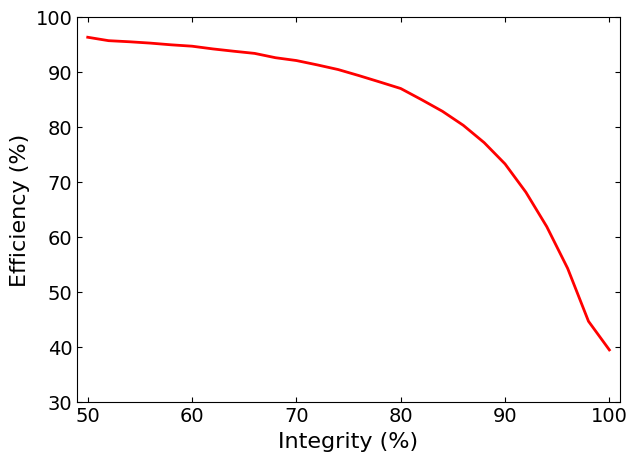

In [28]:
plt.figure(figsize=(7, 5))
plt.plot(xlist, eff, alpha=1, label='Efficiency', linewidth=2, color='red')
plt.xlim([49, 101])
plt.ylim([30, 100])
plt.xlabel('Integrity (%)', fontsize=16)
plt.ylabel('Efficiency (%)', fontsize=16)
plt.tick_params(axis='both', 
                which='major', 
                labelsize=14,
                top=True,
                bottom=True,
                left=True,
                right=True,
                direction='in')
plt.yticks(np.arange(30, 110, 10))
#plt.grid(True)
plt.show()
#plt.savefig("Efficiency_vs_Integrity.pdf")